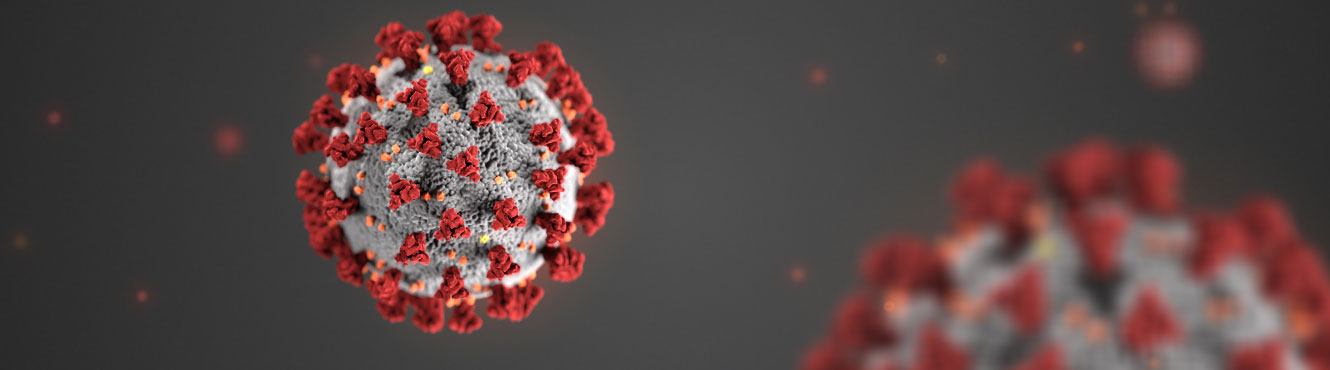

# Coronavirus disease (COVID-19)

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

The disease was first detected in the city of Wuhan China, in November 2019.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes, making it important that people regularly wash their hands and practice respiratory etiquette (for example, by coughing into a flexed elbow).

Datasets used:
 - https://www.kaggle.com/vignesh1694/covid19-coronavirus
 

## Packages and data loading

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import math

register_matplotlib_converters()
sns.set()

from pathlib import Path
data_dir = Path('../input/covid19-global-forecasting-week-1')

In [ ]:
df = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])

# Renaming, re-ordering and creating a current cases column
df = df.rename(columns={'Deaths':'Deceased', 'Province/State':'Province', 'Country/Region':'Country'})
df['Current'] = df['Confirmed'] - df['Deceased'] - df['Recovered']
df = df[['Country','Province', 'Lat', 'Long', 'Date','Confirmed', 'Current', 'Recovered', 'Deceased']]
df.head()

# Exploratory data analysis
## A global view of the pandemic 
Initial graphing of how the virus has evolved over time, showing the total number of confirmed cases, current cases, recovered cases and deceased cases since the beginning of the outbreak. 

In [ ]:
# Grouping the data globally
globally = df[df.columns.values[-5:]].groupby('Date').sum().reset_index()

# Creating a loop for the various plots
plt.subplots(nrows=2, ncols=2, figsize=(20,10))
i = 0
for graph in globally.columns.values[1:]:
    i += 1
    plt.subplot(2,2,i)
    plt.plot(globally[graph]/1e3, label = graph)
    plt.title('Global ' + graph + ' Cases')
    plt.xlabel('Days (starting 2020-01-22)')
    plt.ylabel('Thousand Cases')
    plt.xlim(globally.index.min(), globally.index.max())
    plt.legend(loc='best')

print('As of', globally.Date.dt.date.max(),':')
print(int(globally.Confirmed.max()), 'Confirmed cases')
print(int(globally.Current.max()), 'Current cases')
print(int(globally.Recovered.max()), 'Recovered cases')
print(int(globally.Deceased.max()), 'Deceased cases')

### Global mortality rating
The mortality has been calculated from the total number of resolved cases and not counting ongoing as they haven't yet concluded. These cases are those that have either ended in recovery $R$ or as a fatality (Deceased) $F$, resolved = Recovery + fatality. 

$$ Mortality= \frac{\sum F}{\sum R + F} $$

In [ ]:
resolved_cases = globally['Recovered'].sum() + globally['Deceased'].sum()
mortality = round(100 * (globally['Deceased'].sum() / resolved_cases), 2)
print('Currently the global mortality rate is:', mortality, '%')

The mortality rate calculated above is higher than previously estimated, though this is concerning to see a difference and for it to be significantly higher. A possible cause might be that only the more serious cases are now being confirmed due to the number of testing kits available and health care capacities around the globe. 

This limited capability in confirming new cases would result in a reduced number of confirmed and recovered cases being reported. Making the mortality rate disproportionally representative of only more serious cases.

### Top 10 most affected countries
A look into the top 10 affected countries so far and seeing a break down of how the cases are distributed. In this part China and Italy are of key intreset as the two most affected countries. 

In [ ]:
latest = df.loc[df['Date'] == df['Date'].max()].groupby('Country').sum().reset_index()

latest = latest.sort_values(by=['Confirmed'], ascending=False).reset_index(drop=True)
top_10 = latest.loc[:9]
top_10_bar = top_10.set_index('Country')[top_10.columns[3:]]
top_10_names = top_10['Country']

(top_10_bar/1e3).plot.bar(figsize=(20,5))
plt.ylabel('Thousand Cases')

In the bar plot, China has a marginally higher number of confirmed cases than Italy, however, they have drastically less current cases. Looking at how China currently has less deceased cases than Italy, it is slightly concerning given the fact that Italy is further behind in the progression of the virus. The figures suggest that the number of deceased cases is still set to significantly rise in Italy in the coming weeks, even in the case of no further infections.

## Global distribution of cases
A look into how the cases of COVID-19 are distributed across the globe in terms of current cases by country.

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)    #THIS LINE IS MOST IMPORTANT AS THIS WILL DISPLAY PLOT ON 
#NOTEBOOK WHILE KERNEL IS RUNNING
import plotly.express as px

fig = px.choropleth(latest, locations="Country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Confirmed", range_color=[1,50000], 
                    color_continuous_scale='Reds', 
                    title='Global view of Confirmed Cases')
fig.show()

It can be seen from the graph that currently the most affected countries are China, USA, Iran and Western and Central European countries. Now to look at how these countries have developed over time in terms of cases.

In [ ]:
europe = list(['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
               'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
               'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
               'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

european_countries = df[df['Country'].isin(europe)]
latest_european = european_countries.loc[european_countries['Date'] == european_countries['Date'].max()].groupby('Country').sum().reset_index()

China = df.loc[df['Country'] == 'China'].groupby('Date').sum().reset_index()
Iran = df.loc[df['Country'] == 'Iran'].groupby('Date').sum().reset_index()
USA = df.loc[df['Country'] == 'US'].groupby('Date').sum().reset_index()
EU = european_countries.groupby('Date').sum().reset_index()

# Creating a loop for the various plots
plt.subplots(nrows=2, ncols=2, figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(China['Current']/1e3, label='Current', color='green')
plt.plot(China['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(China['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'China' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(globally.index.min(), globally.index.max())
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(EU['Current']/1e3, label='Current', color='green')
plt.plot(EU['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(EU['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'EU' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(globally.index.min(), globally.index.max())
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(Iran['Current']/1e3, label='Current', color='green')
plt.plot(Iran['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(Iran['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'Iran' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(globally.index.min(), globally.index.max())
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(USA['Current']/1e3, label='Current', color='green')
plt.plot(USA['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(USA['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'USA' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(globally.index.min(), globally.index.max())
plt.legend(loc='best')

In the graphs, the exponential rate of growth of the virus in Europe is of concern as there are currently twice as many cases as having been reported in China throughout the pandemic. What makes these numbers even more concerning is that the population of Europe is roughly 750 million at present, compared with China's population of 1.44 billion. [1] Despite China's population is roughly twice the size, it seems as though the virus is spreading much more aggressively amongst European countries.

[1] - https://www.worldometers.info/world-population/population-by-country/

## Looking further into Europe
Given that the growth rate in Europe is so high by comparison to China, a further investigation will be made into Europe to look at how the virus is spreading on a country by country level.

### Spread over Europe

In [ ]:
fig = px.choropleth(latest_european, locations="Country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Confirmed", range_color=[1,5000], 
                    color_continuous_scale='Reds', 
                    title='European view of Current Cases', scope='europe')#, height=800, width= 1400)
# fig.update(layout_coloraxis_showscale=False)
fig.show()

### A visualisation on a country by country level of Eurpoe
A further look into the most affected countries of Europe. The virus didn't spread to Europe until about 30 days had passed in the dataset, therefore I will start the graphs from there. 

In [ ]:
Italy = df.loc[df['Country'] == 'Italy'].groupby('Date').sum().reset_index()
UK = df.loc[df['Country'] == 'United Kingdom'].groupby('Date').sum().reset_index()
France = df.loc[df['Country'] == 'France'].groupby('Date').sum().reset_index()
Spain = df.loc[df['Country'] == 'Spain'].groupby('Date').sum().reset_index()
Germany = df.loc[df['Country'] == 'Germany'].groupby('Date').sum().reset_index()
Switzerland = df.loc[df['Country'] == 'Switzerland'].groupby('Date').sum().reset_index()

# Creating a loop for the various plots
plt.subplots(nrows=3, ncols=2, figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(Italy['Current']/1e3, label='Current', color='green')
plt.plot(Italy['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(Italy['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'Italy' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

plt.subplot(2,3,2)
plt.plot(Germany['Current']/1e3, label='Current', color='green')
plt.plot(Germany['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(Germany['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'Germany' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

plt.subplot(2,3,3)
plt.plot(Spain['Current']/1e3, label='Current', color='green')
plt.plot(Spain['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(Spain['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'Spain' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

plt.subplot(2,3,4)
plt.plot(France['Current']/1e3, label='Current', color='green')
plt.plot(France['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(France['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'France' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

plt.subplot(2,3,5)
plt.plot(Switzerland['Current']/1e3, label='Current', color='green')
plt.plot(Switzerland['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(Switzerland['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'Switzerland' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

plt.subplot(2,3,6)
plt.plot(UK['Current']/1e3, label='Current', color='green')
plt.plot(UK['Recovered']/1e3, label='Recovered', color='orange')
plt.plot(UK['Deceased']/1e3, label='Deceased', color='red')
plt.title('Global ' + 'UK' + ' Cases')
plt.xlabel('Days (starting 2020-01-22)')
plt.ylabel('Thousand Cases')
plt.xlim(30, 60)
plt.legend(loc='best')

The graphs reveal a lot of insight into the way the virus is spreading throughout Europe, current it appears as though all nations are in an exponential growth phase of the virus. In terms of Italy and Spain the mortality rates appear to relatively high, the trends show nearly as many cases are unfortunately resulting in a fatality as a recovery. Again though this could very likely be due to the severity of the cases officially being reported as the health care systems are becoming overloaded and only handling the most severe cases. 

The result of the virus will be difficult to predict, this is highlighted in a comparison of the  Germany and Spain graphs. The two countries have very similar current case trends, however, the majority of the Germany cases haven't yet been concluded making it hard to determine the outcome.